In [2]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import data.s3 as s3u
import evaluation.eval_framework as efu

import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt

# Import results

In [3]:
s3 = s3u.s3_utils()

regions = ['CAISO_NORTH',
 'SPP_TX',
 'ERCOT_EASTTX',
 'FPL',
 'SOCO',
 'PJM_CHICAGO',
 'PJM_DC',
 'LDWP',
 'NYISO_NYC'
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240726_1k_synth_users_163_days_{r}.csv"
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data = pd.concat(dfs)

CAISO_NORTH
SPP_TX
ERCOT_EASTTX
FPL
SOCO
PJM_CHICAGO
PJM_DC
LDWP
NYISO_NYC


## Metrics

In [85]:
results_data["ideal_difference"] = results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
results_data["baseline_difference"] = results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
results_data["estimated_difference"] = results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
results_data["largest_possible_difference"] = results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]

results_data["largest_difference_normalized"] = np.divide(results_data["largest_possible_difference"],results_data["power_output_rate"])
results_data["baseline_difference_normalized"] = np.divide(results_data["baseline_difference"],results_data["power_output_rate"])
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

results_data["plug_in_time_of_day"] = pd.to_datetime(results_data["plug_in_time"]).dt.time
results_data["yyyy-mm"] = results_data["distinct_dates"].str[:7]

## Data Checks

The users vary in three main ways:
* MWh_fraction: the amount of charge the user can draw in a 5 minute interval (in MWh)
* charged_kWh_actual: the total amount of charge the user draws
* num_intervals_plugged_in: the number of intervals the user is plugged in for
* plug_in_time: a plug in time uniformly distributed between 5pm and 9pm local time


Then forecast varies in two main ways:
* distinct_dates: 163 randomly chosen dates from between 2023/01/02 and 2024/07/26, two per week
* Region: from each of the 9 regions CAISO_NORTH, SPP_TX, ERCOT_EASTTX, FPL, SOCO, PJM_CHICAGO, PJM_DC, LDWP, NYISO_NYC

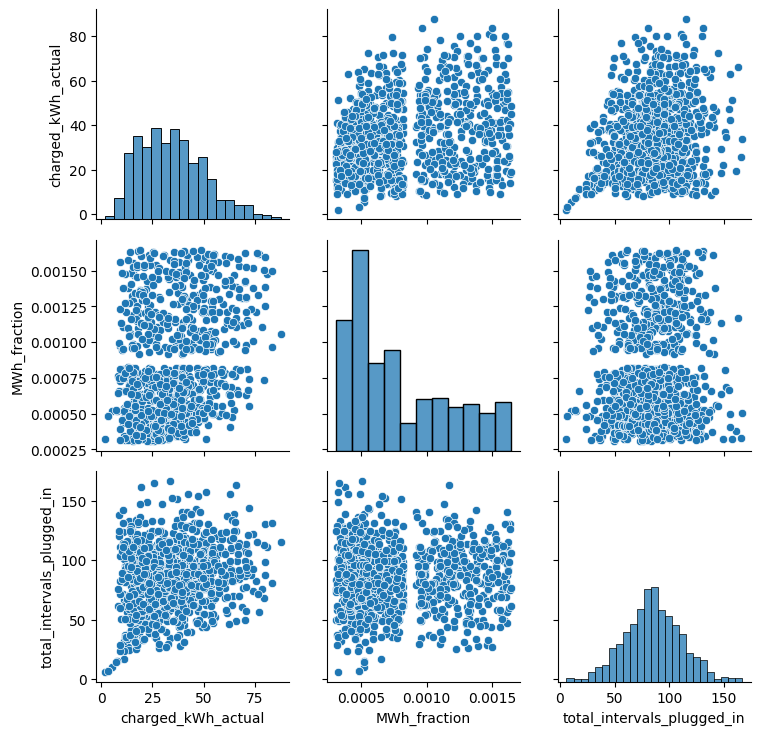

In [70]:

sample_one_region_day_synth_data = results_data.query("region=='CAISO_NORTH' and distinct_dates=='2023-01-02'")[["charged_kWh_actual", "MWh_fraction", "total_intervals_plugged_in", "plug_in_time_of_day"]]
g = sns.PairGrid(sample_one_region_day_synth_data)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

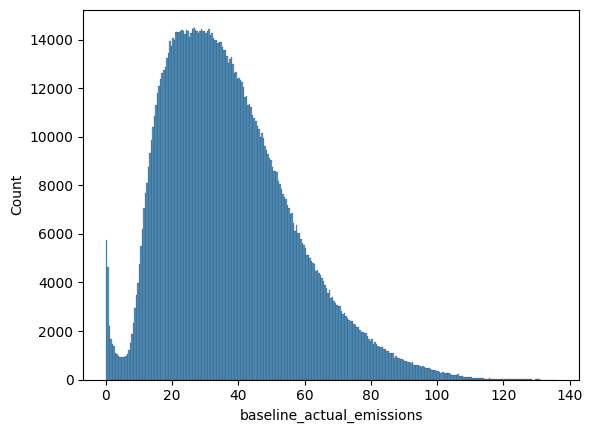

In [14]:
# near zero values unlikely, data error?
# Robin: I think this is expected, some of the synth users are plugged in for a near-zero number of intervals
sns.histplot(results_data["baseline_actual_emissions"])

## Largest Possible Gain from Simple Optimization
- run the simple optimizer on actual emissions data
- subtract from baseline

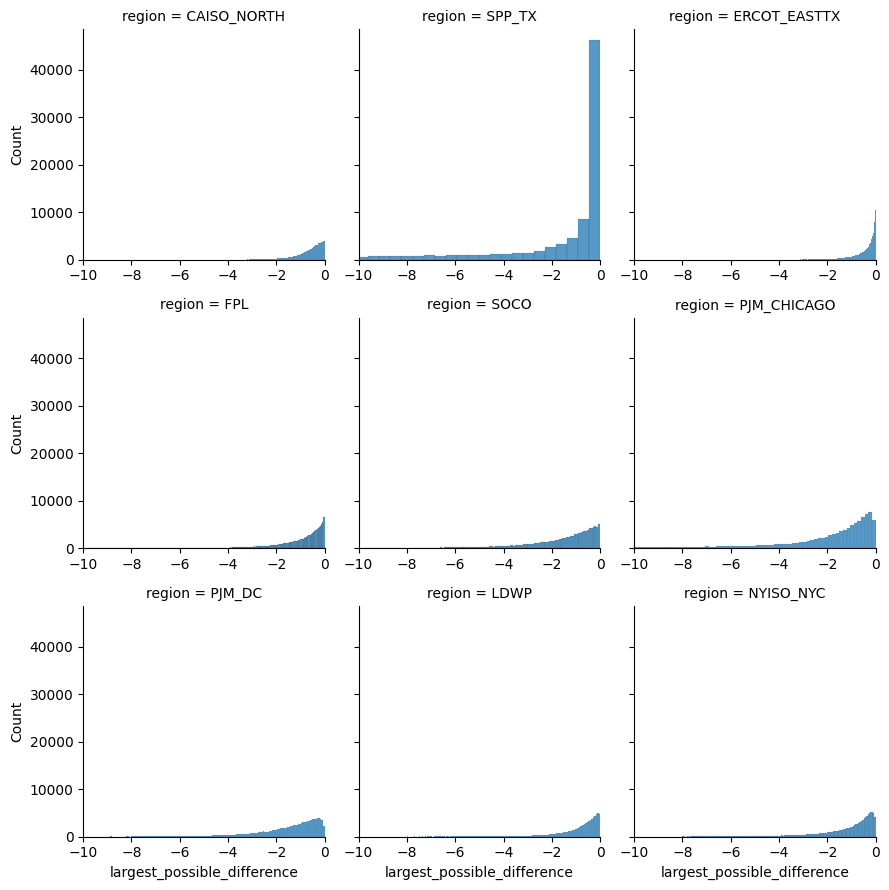

In [36]:
g = sns.FacetGrid(results_data.query('largest_possible_difference != 0'), col="region",sharex=False, col_wrap=3)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)
    ax.set_xlim(left=-10, right=0)

g.map(hist_w_xlim, "largest_possible_difference")

With perfect foresight, using the simple optimizer, what's the most emissions we can avoid in total for all users in each region?

In [11]:
results_data.groupby("region")["largest_possible_difference"].sum()

region
CAISO_NORTH     -85483.504532
ERCOT_EASTTX   -172364.661388
FPL            -115816.834650
LDWP           -129279.929052
PJM_CHICAGO    -498689.538093
PJM_DC         -178019.981538
SPP_TX         -892227.225518
Name: largest_possible_difference, dtype: float64

In [12]:
# Robin: this statistic is mostly a property of our synth user data: whether they have to charge for the entire window or have slack time
results_data.groupby('region')["optimization_possible"].value_counts(normalize=True)

region        optimization_possible
CAISO_NORTH   True                     0.693883
              False                    0.306117
ERCOT_EASTTX  True                     0.680982
              False                    0.319018
FPL           True                     0.694724
              False                    0.305276
LDWP          True                     0.692055
              False                    0.307945
PJM_CHICAGO   True                     0.696055
              False                    0.303945
PJM_DC        True                     0.695914
              False                    0.304086
SPP_TX        True                     0.688417
              False                    0.311583
Name: proportion, dtype: float64

How much of the largest possible difference do we capture per region? Between 60% and 73%

In [92]:
results_data.groupby("region")["baseline_difference"].sum() / results_data.groupby("region")["largest_possible_difference"].sum().sort_values()

region
CAISO_NORTH     0.732114
ERCOT_EASTTX    0.464615
FPL             0.958102
LDWP            0.541219
NYISO_NYC       0.853473
PJM_CHICAGO     0.494622
PJM_DC          0.798613
SOCO            0.930808
SPP_TX          0.597924
dtype: float64

Is there seasonality in the largest possible difference?

Yes for Florida (Miami) and SOCO (Atlanta).

SPP_TX and PJM_CHICAGO otherwise have some days with large reductions

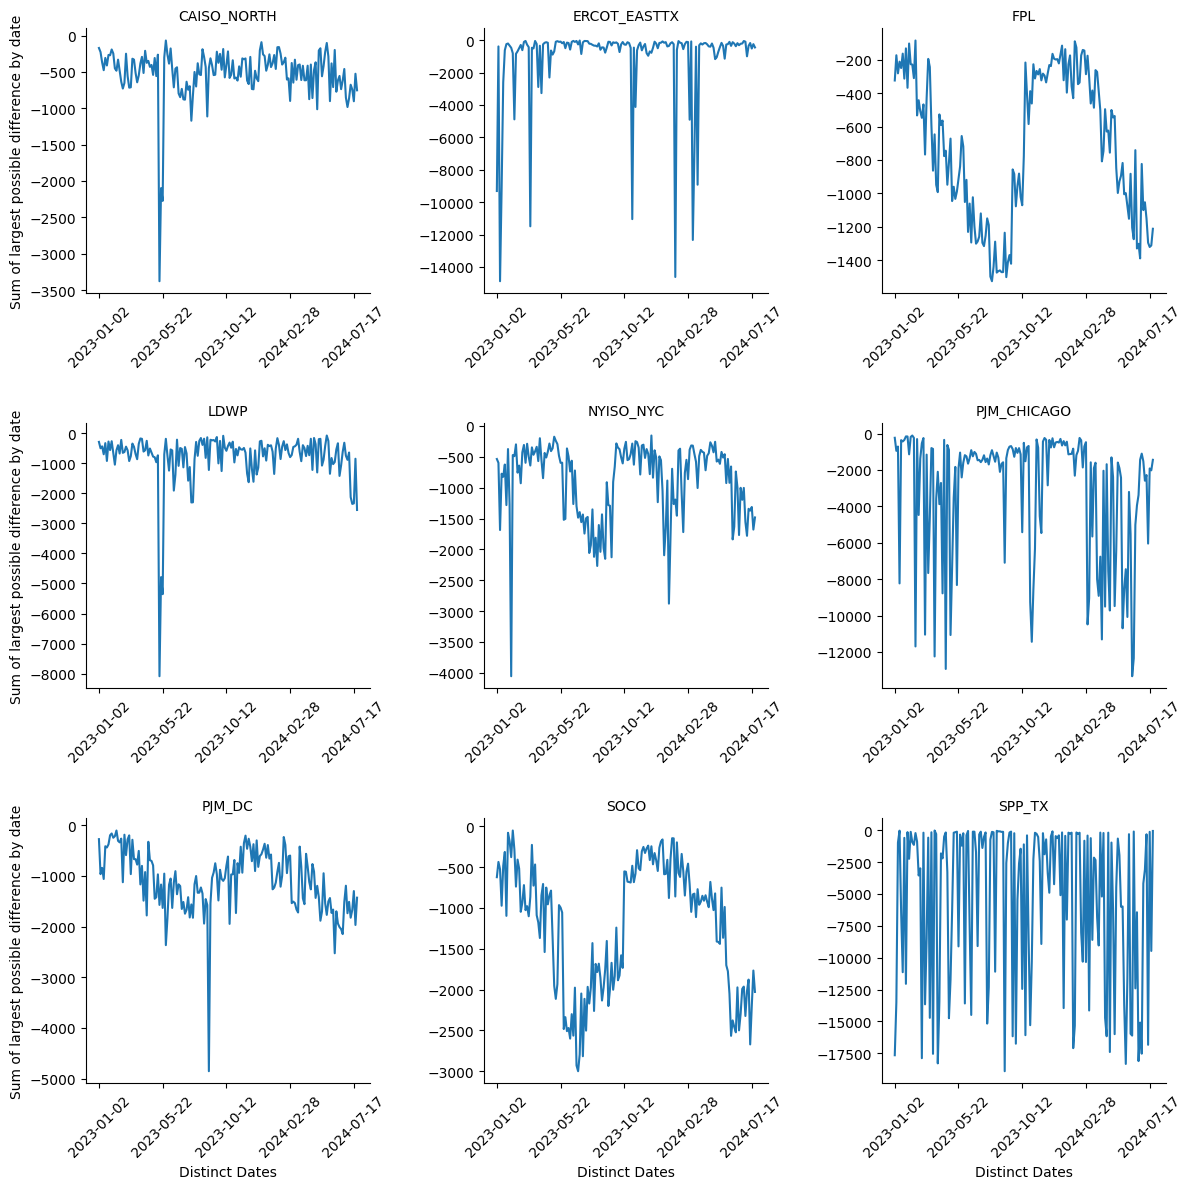

In [100]:
grouped_data = results_data.groupby(['distinct_dates', 'region'])['largest_possible_difference'].sum().reset_index()
g = sns.FacetGrid(grouped_data, col='region', col_wrap=3, sharex=False, sharey=False, height=4, aspect=1)

def plot_sum(data, **kwargs):
    ax = sns.lineplot(data=data, x='distinct_dates', y='largest_possible_difference', **kwargs)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::max(1, len(xticks) // 4)])  # Reduce the number of xticks to a maximum of 4
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
g.map_dataframe(plot_sum)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Distinct Dates", "Sum of largest possible difference by date")
plt.show()


<Axes: title={'center': 'Percentaged of maximum savings achieved by region by month'}, xlabel='yyyy-mm', ylabel='region'>

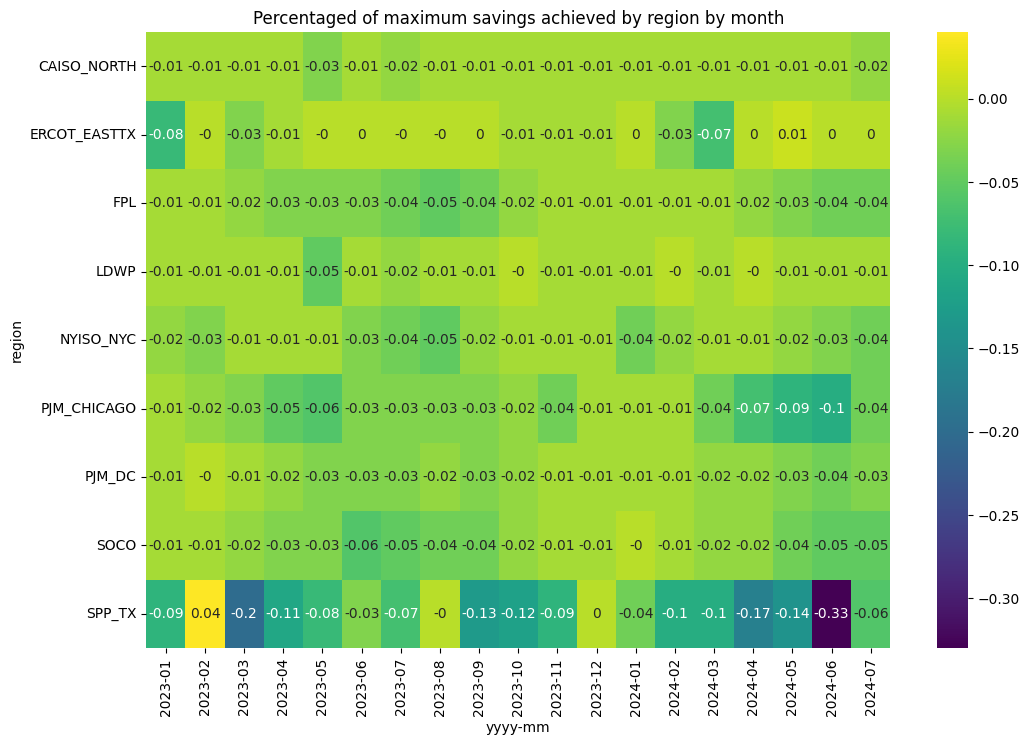

In [91]:
percent_ideal_achieved = (results_data.groupby(["region", "yyyy-mm"])["baseline_difference"].sum() / results_data.groupby(["region", "yyyy-mm"])["baseline_actual_emissions"].sum()).unstack(level=1).round(2)

plt.subplots(figsize=(12, 8))
plt.title("Percentaged of maximum savings achieved by region by month")

sns.heatmap(percent_ideal_achieved, annot=True, cmap="viridis")

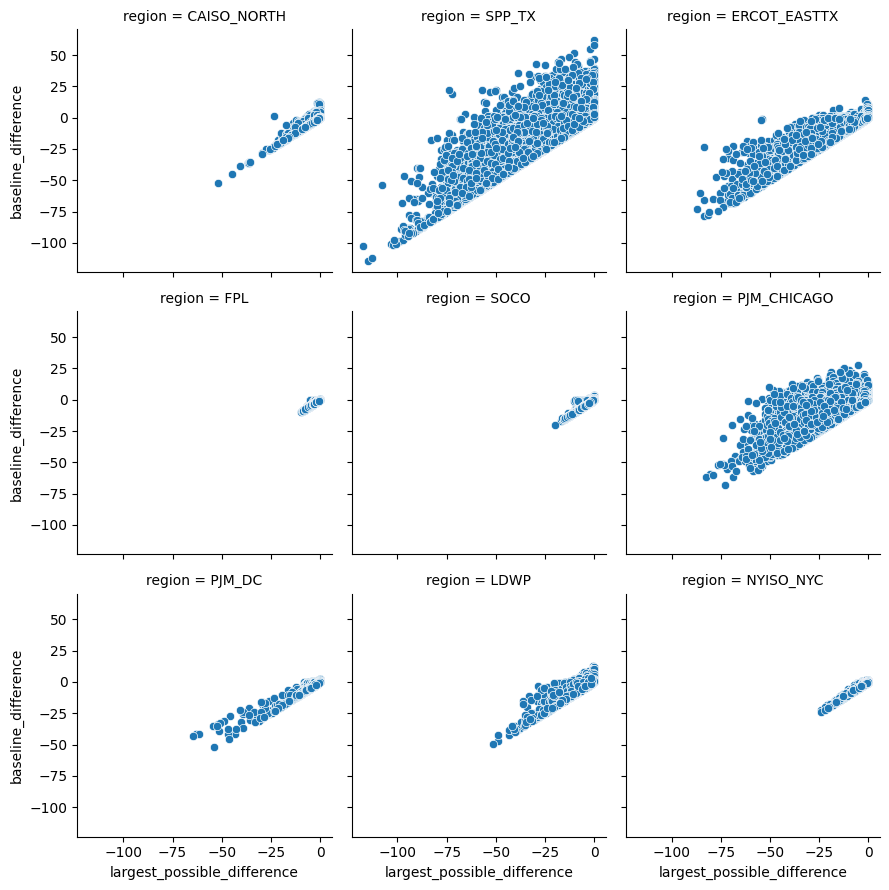

In [18]:
g = sns.FacetGrid(results_data, col="region", col_wrap=3)
g.map(sns.scatterplot, "largest_possible_difference", "baseline_difference")

Correlated with number of intervals plugged in.

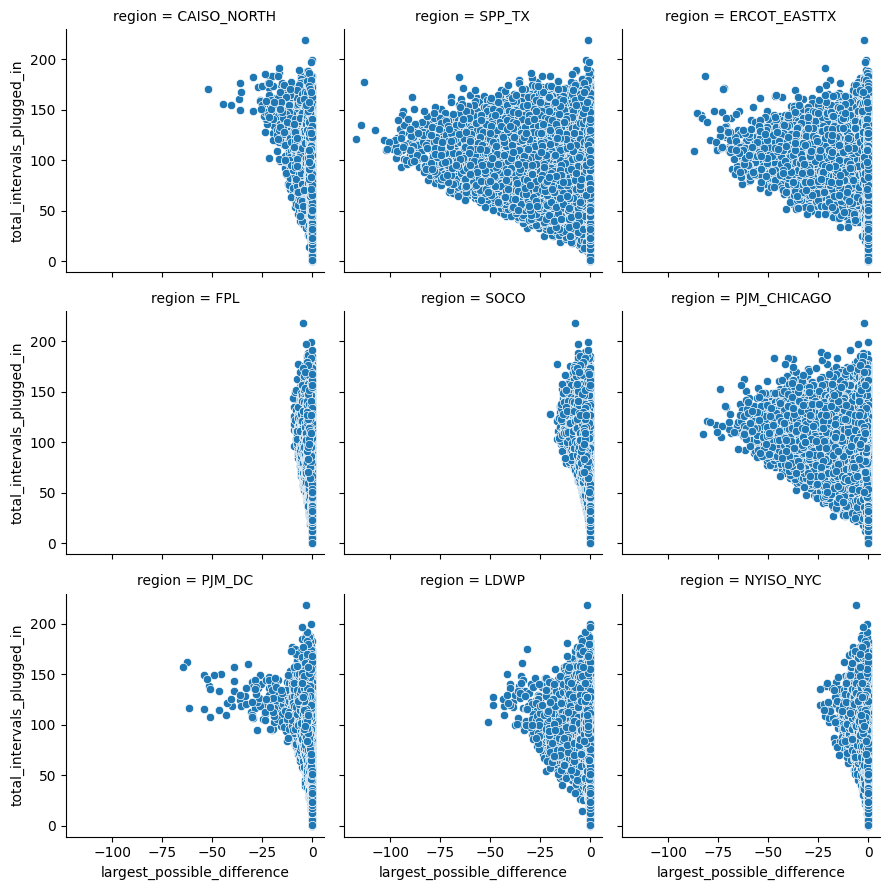

In [16]:
g = sns.FacetGrid(results_data, col="region", col_wrap=3)
g.map(sns.scatterplot, "largest_possible_difference", "total_intervals_plugged_in")

correlated with power output rate

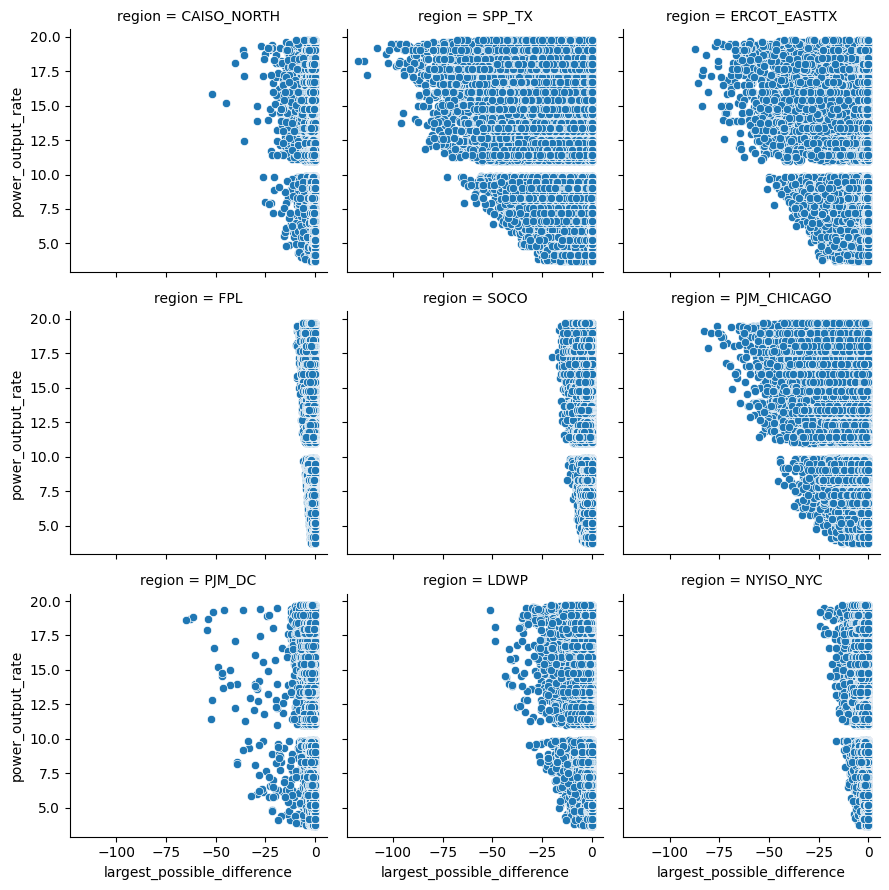

In [101]:
g = sns.FacetGrid(results_data, col="region", col_wrap=3)
g.map(sns.scatterplot,"largest_possible_difference", "power_output_rate")

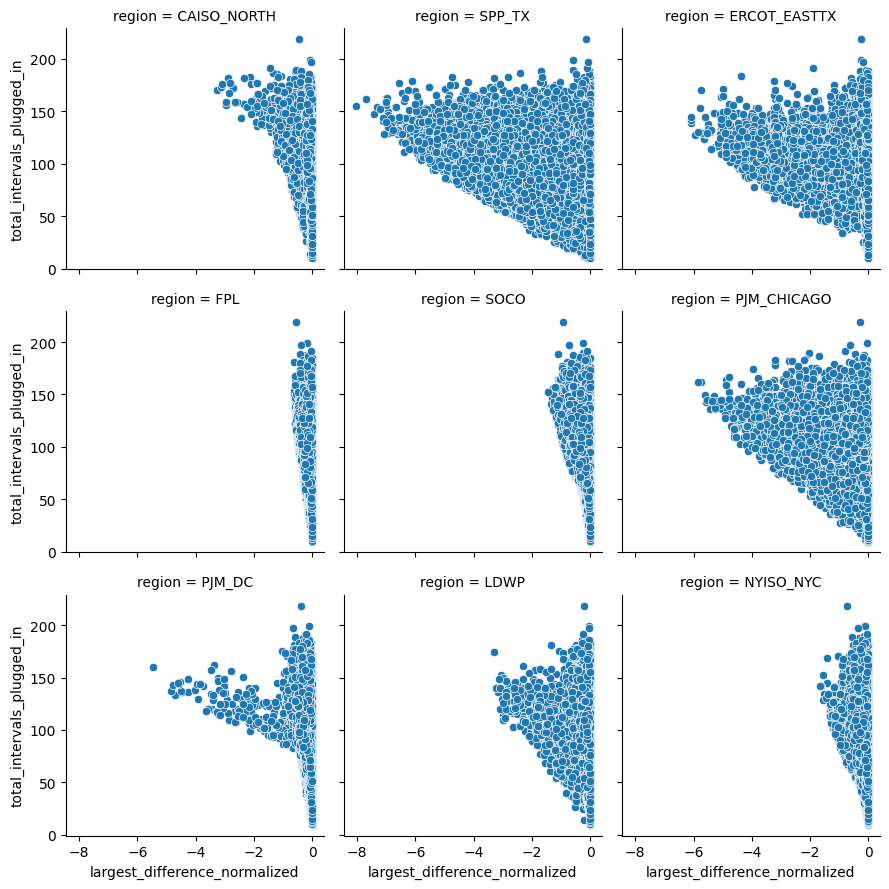

In [102]:
# things get interesting when you're plugged in for over 4 hours. Could reexpress this as odds.
g = sns.FacetGrid(results_data.query('largest_difference_normalized < 0'), col="region", col_wrap=3)
g.map(sns.scatterplot,"largest_difference_normalized", "total_intervals_plugged_in")

- normalize the difference to account for variation in power output rate
For each region, the minimum amount of time plugged in to see benefit varies for an "overnight" charge. 
- For DC, we see that you often need to be plugged in for a longer timespan to optimize, whereas ERCOT East is about 1/2 that time. (when observing the theoretical)

## Optimization Achieved
- baseline difference  = simple optimization "actual" emissions / baseline "actual" emissions
- percent of ideal = baseline difference / largest_possible_difference
- it's possible to accidently consume more emissions that baseline with the optimizer.

In [10]:
results_data.query("region=='CAISO_NORTH' and distinct_dates=='2023-01-02'")

,user_type,power_output_rate,distinct_dates,plug_in_time,total_intervals_plugged_in,charged_kWh_actual,MWh_fraction,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions,region,ideal_difference,baseline_difference,estimated_difference,largest_possible_difference,largest_difference_normalized,baseline_difference_normalized,optimization_possible
0,r4.181_tc76_avglc28022_sdlc7793,4.1810,2023-01-02,2023-01-02 20:06:14,78.682387,27.414255,0.000348,27.091486,27.091486,26.486043,27.091486,CAISO_NORTH,0.000000,0.000000,0.605444,0.000000,0.000000,0.000000,False
163,r6.3714_tc78_avglc29422_sdlc6959,6.3714,2023-01-02,2023-01-02 19:07:56,110.825532,36.373802,0.000531,36.056284,36.073274,34.966562,36.004250,CAISO_NORTH,-0.052033,-0.016990,1.089722,-0.069024,-0.010833,-0.002667,True
326,r18.215999999999998_tc117_avglc27109_sdlc7687,18.2160,2023-01-02,2023-01-02 18:34:16,122.445381,73.949130,0.001518,73.254126,73.396818,70.907146,72.964188,CAISO_NORTH,-0.289938,-0.142692,2.346980,-0.432630,-0.023750,-0.007833,True
489,r6.6008000000000004_tc23_avglc29044_sdlc7821,6.6008,2023-01-02,2023-01-02 18:26:49,92.254390,14.826646,0.000550,14.584468,14.753338,14.161961,14.523960,CAISO_NORTH,-0.060507,-0.168870,0.422506,-0.229378,-0.034750,-0.025583,True
652,r3.8776_tc34_avglc28815_sdlc7696,3.8776,2023-01-02,2023-01-02 17:32:31,149.150632,22.277678,0.000323,21.958526,22.087456,21.248117,21.910056,CAISO_NORTH,-0.048470,-0.128930,0.710409,-0.177400,-0.045750,-0.033250,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162185,r9.042_tc41_avglc23897_sdlc7349,9.0420,2023-01-02,2023-01-02 17:02:08,45.258061,26.663087,0.000753,27.052910,27.212652,26.112090,26.997151,CAISO_NORTH,-0.055759,-0.159742,0.940820,-0.215501,-0.023833,-0.017667,True
162348,r15.421999999999999_tc47_avglc26261_sdlc7559,15.4220,2023-01-02,2023-01-02 20:27:17,99.438688,22.011295,0.001285,22.834841,22.615078,22.033668,22.573952,CAISO_NORTH,-0.260889,0.219763,0.801173,-0.041125,-0.002667,0.014250,True
162511,r11.440000000000001_tc71_avglc29935_sdlc7755,11.4400,2023-01-02,2023-01-02 19:54:43,88.683185,41.343910,0.000953,41.311747,41.258360,40.037998,41.120127,CAISO_NORTH,-0.191620,0.053387,1.273749,-0.138233,-0.012083,0.004667,True
162674,r5.217_tc74_avglc21924_sdlc7840,5.2170,2023-01-02,2023-01-02 18:48:57,117.996246,44.149954,0.000435,43.687593,43.735415,42.439556,43.686288,CAISO_NORTH,-0.001304,-0.047822,1.248037,-0.049127,-0.009417,-0.009167,True


<Axes: xlabel='region'>

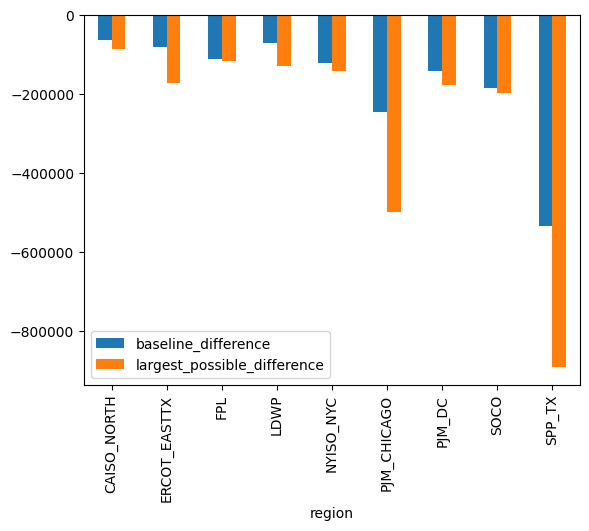

In [43]:
# may look different after cleaning up the data? We should perhaps check the historic actuals for missing values
results_data.groupby('region')[['baseline_difference', 'largest_possible_difference']].sum().plot(kind="bar")

In [18]:
results_data.groupby('region')['baseline_difference'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CAISO_NORTH,163000.0,-0.383949,0.920400,-52.093452,-0.539723,-0.113400,0.000000,12.359026
ERCOT_EASTTX,163000.0,-0.491308,3.634896,-78.659504,-0.082582,0.000000,0.063218,14.302337
FPL,163000.0,-0.680763,1.005167,-9.727685,-0.984817,-0.254528,0.000000,0.587560
LDWP,163000.0,-0.429256,1.409061,-49.564619,-0.554707,-0.038460,0.000000,12.587863
PJM_CHICAGO,163000.0,-1.513268,3.846402,-68.006389,-1.601149,-0.288621,0.000000,28.180152
PJM_DC,163000.0,-0.872203,1.418837,-51.870362,-1.289354,-0.300251,0.000000,2.553672
SPP_TX,163000.0,-3.272907,10.177693,-114.718296,-0.887035,0.000000,0.237822,61.711650


<Axes: xlabel='distinct_dates'>

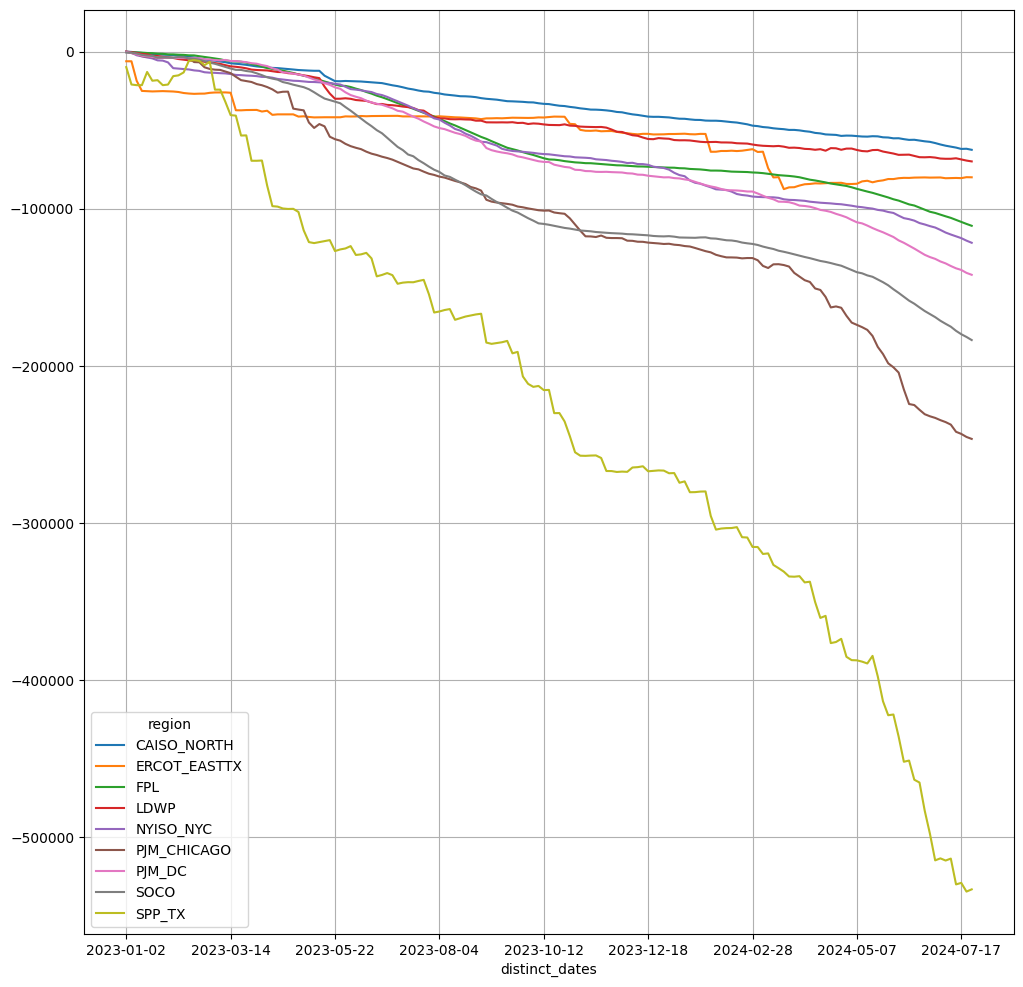

In [40]:
# how do the cumulative emissions saved over time look for different regions?
results_data.groupby(["region", "distinct_dates"])["baseline_difference"].sum().unstack(level=0).cumsum().plot(grid=True, figsize=(12, 12))

In [20]:
results_data['percent_ideal_achieved'] = np.divide(
    results_data['baseline_difference'],
    results_data['largest_possible_difference'],
    )
results_data['percent_ideal_achieved'] = results_data['percent_ideal_achieved'].replace([np.inf, -np.inf], np.nan)

In [21]:
# these look a bit fishy to me? Not sure...
# Robin: the large negative values would be from when there is a small possible reduction but we end up doing an increase instead
results_data.groupby('region')['percent_ideal_achieved'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CAISO_NORTH,113103.0,-0.296344,16.104362,-1677.0,0.443965,0.816054,0.941927,1.0
ERCOT_EASTTX,111000.0,-7.315431,64.347369,-5061.0,-1.365028,0.006393,0.501748,1.0
FPL,113240.0,0.410442,9.190694,-1041.0,0.908438,0.988490,0.999955,1.0
LDWP,112805.0,-3.206601,211.384730,-44143.0,0.050334,0.584401,0.853831,1.0
PJM_CHICAGO,113457.0,0.408953,4.951012,-1447.0,0.329154,0.706173,0.910952,1.0
PJM_DC,113434.0,0.395231,8.048179,-712.5,0.503557,0.803365,0.932989,1.0
SPP_TX,112212.0,-14.318664,176.211648,-30542.0,-2.666667,0.006863,0.775722,1.0


- overnight opportunity for improvement vary by region?
- FPL little variation in energy mix
- CAISO missing daylight solar for overnight test cases

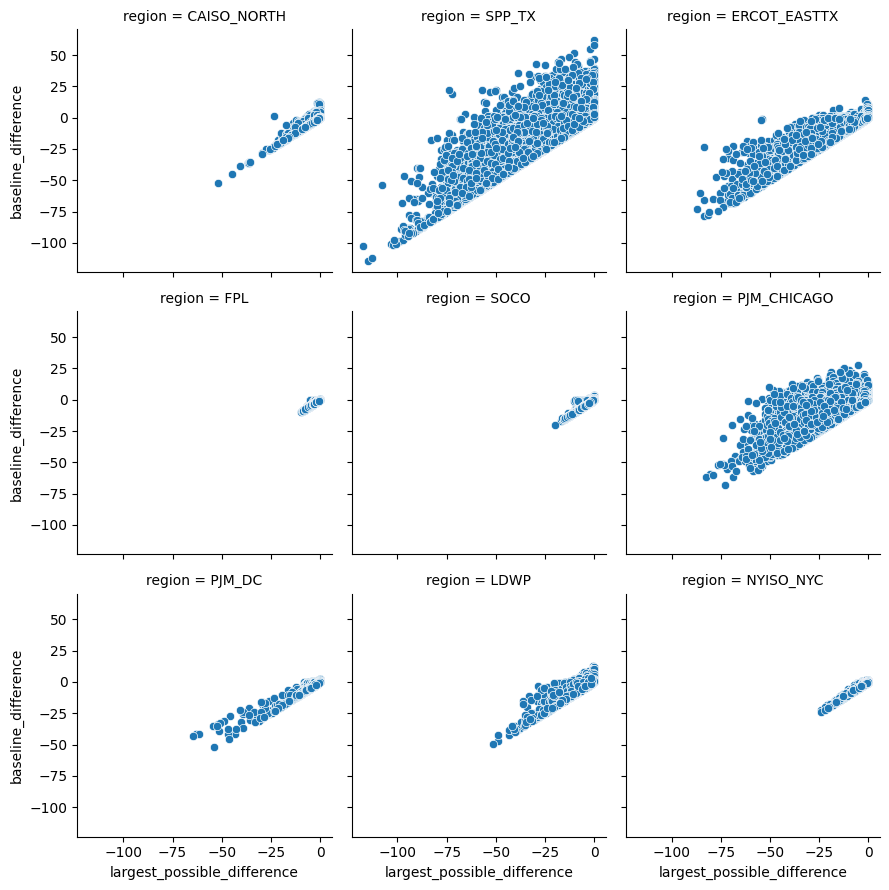

In [44]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"largest_possible_difference", "baseline_difference")

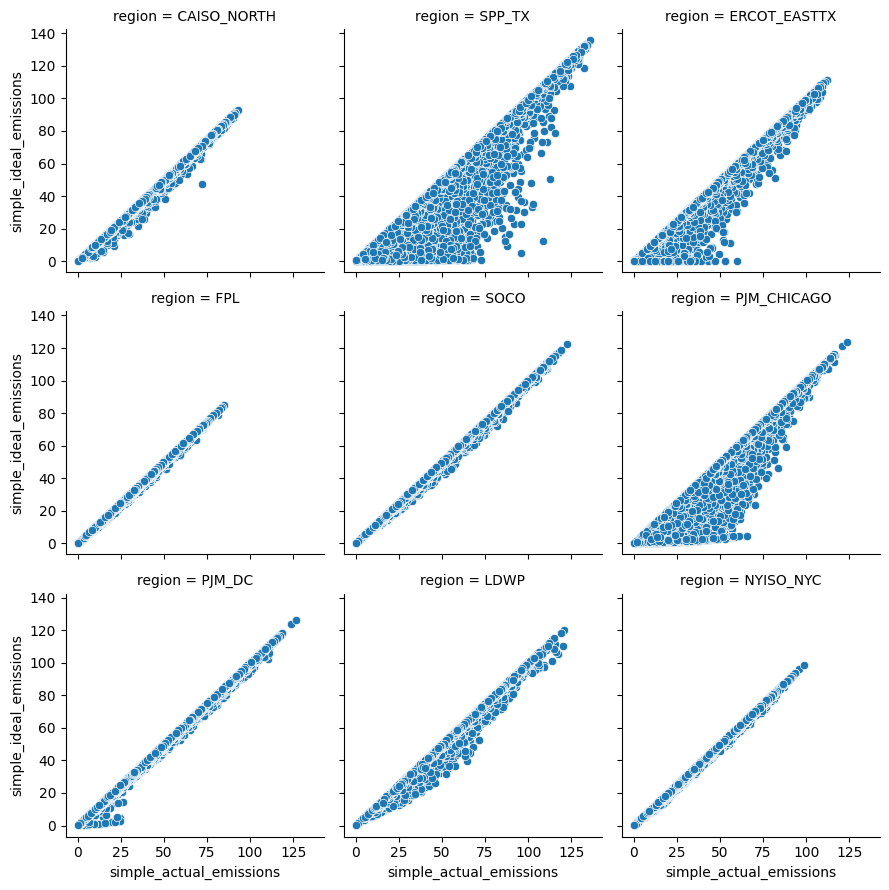

In [11]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "simple_ideal_emissions")

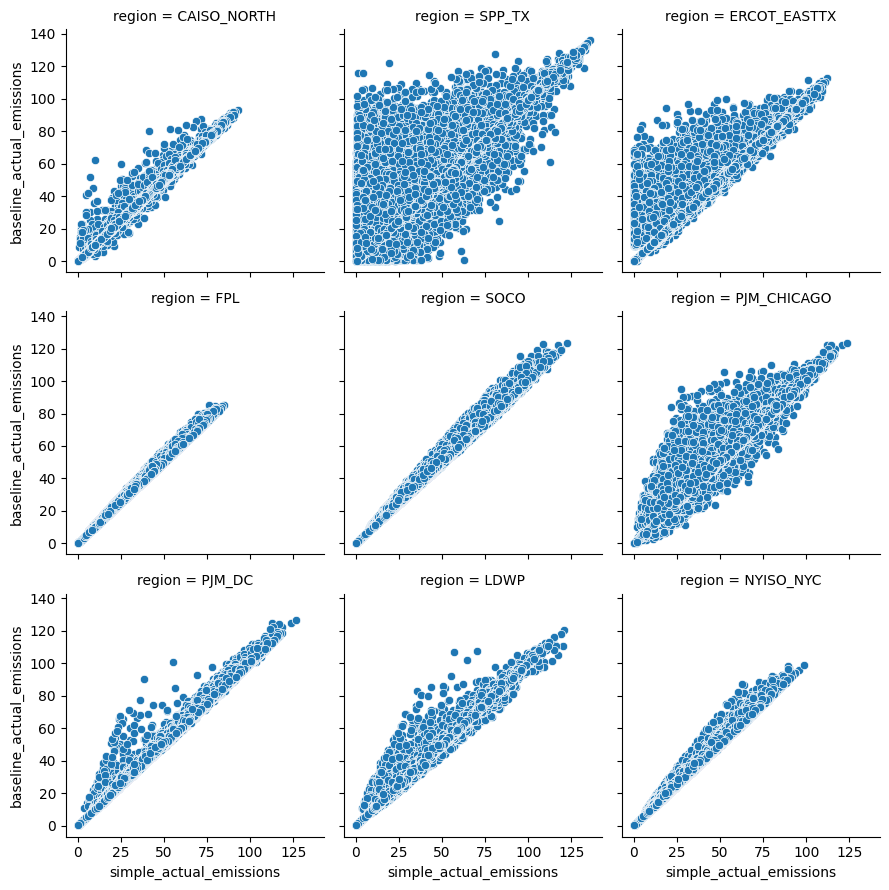

In [12]:
g = sns.FacetGrid(results_data, col="region", col_wrap = 3)
g.map(sns.scatterplot,"simple_actual_emissions", "baseline_actual_emissions")

<Axes: title={'center': 'Likelihood that the charging plan decreased emissions by region by month'}, xlabel='yyyy-mm', ylabel='region'>

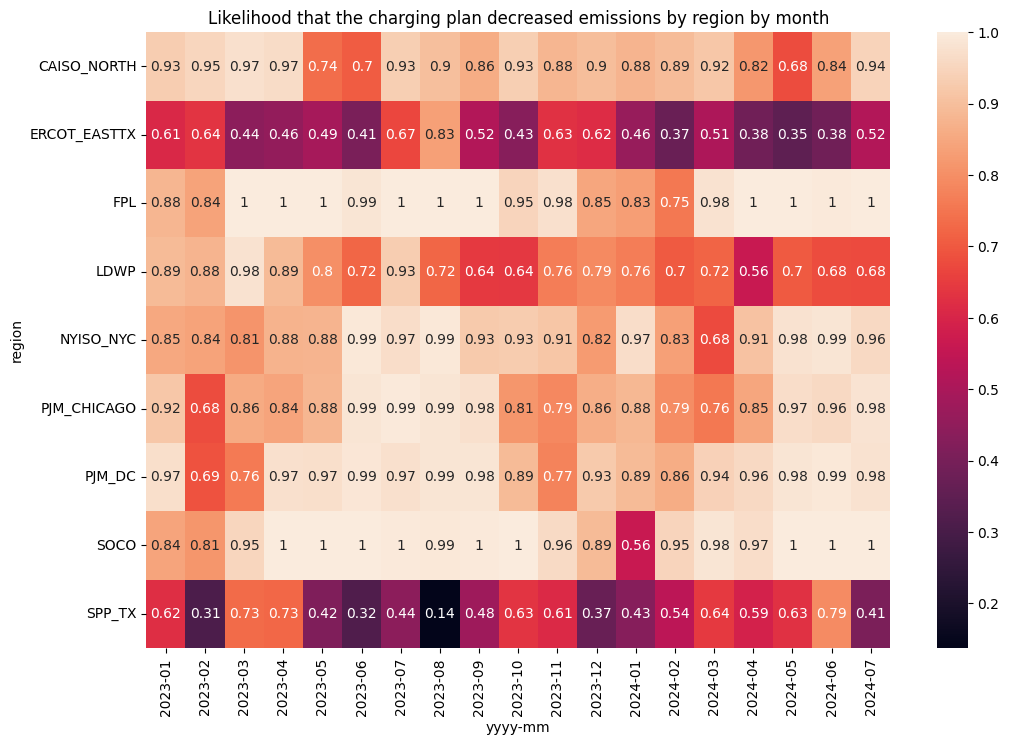

In [13]:
# percentage of times that, when baseline_diff is nonzero, it is negative (i.e. saved emission)
saved_emissions_pct_times = results_data.groupby(["region", "yyyy-mm"])["baseline_difference"].apply(lambda s: len(s[s<0]) / len(s[s!=0])).unstack(level=1)

plt.subplots(figsize=(12, 8))
plt.title("Likelihood that the charging plan decreased emissions by region by month")

sns.heatmap(saved_emissions_pct_times, annot=True)

Does it amount of largest possible savings vary depending on plug in time?
No -- the lines here are all fairly straight

<Axes: title={'center': 'cumulative emissions savings by plug in time of day'}, xlabel='plug_in_time_of_day'>

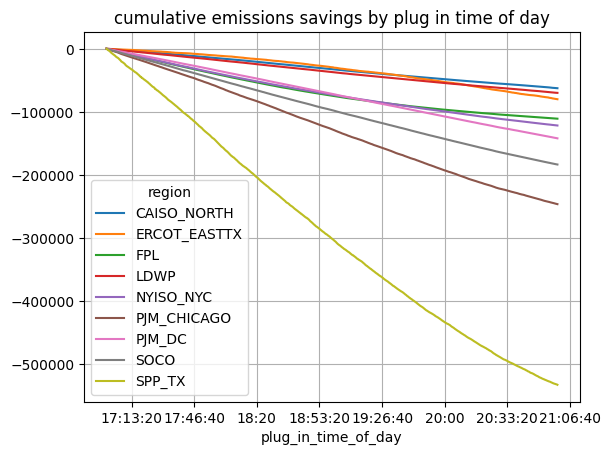

In [68]:
results_data.groupby(["plug_in_time_of_day", "region"])["baseline_difference"].sum().unstack(level=1).cumsum().plot(
    grid=True,
    title="cumulative emissions savings by plug in time of day")